**Machine Learning Algorithms**

This notebook is inspired from the handson-ml2 GitHub repository by Aurélien Geron

https://github.com/ageron/handson-ml2

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Linear regression using the Normal Equation

In [2]:
# Let’s generate some linear-looking data to test the Normal Equation
# The function that we will use to generate the data is y = 4 + 3x1 + Gaussian noise

import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

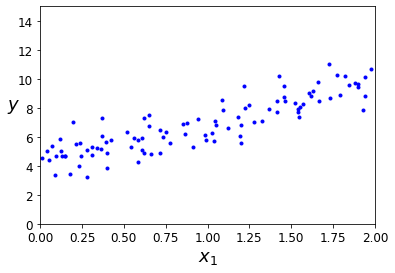

In [3]:
# Plotting the data created in the previous step

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [4]:
# Compute theta-hat using the Normal Equation.

X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance

# Using inv() and dot() to compute inverse and matrix multiplication respectively
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
# Let's check the findings of the equation

theta_best # close enough but he noise made it impossible to recover the exact parameters of the original function

array([[4.21509616],
       [2.77011339]])

In [6]:
# Now let's make the predictions

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

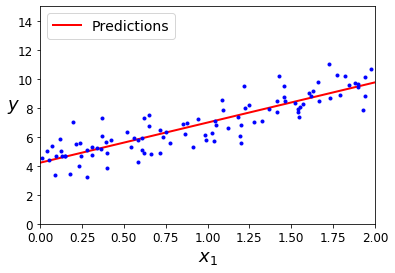

In [7]:
# Let's plot the model's predictions

plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

## Linear Regression using Scikit-learn

In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() # creating an instance of LinearRegression()
lin_reg.fit(X, y) # fitting the data
lin_reg.intercept_, lin_reg.coef_ # finding the intercept and coefficient

(array([4.21509616]), array([[2.77011339]]))

In [9]:
# Predict a value

lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

## Linear regression using Batch Gradient Descent

In [12]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization


# Calculating the Gradient Vector

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [13]:
# Printing the resulting theta

theta

array([[4.21509616],
       [2.77011339]])

In [14]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [15]:
# Creating a function to plot the Gradient Decent

theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

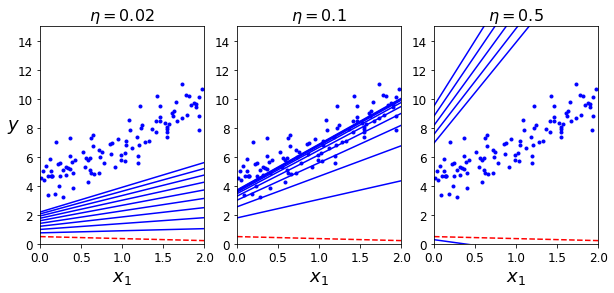

In [16]:
# Plotting the Gradient Descent

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.show()

## Stochastic Gradient Descent

In [17]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

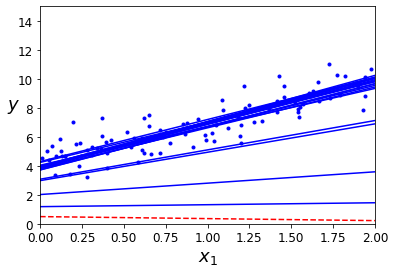

In [18]:
# Creating a Stochastic Gradient Descent using a simple learning schedule

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)          
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)    

# Plotting the Stochastic Gradient Descent we created above

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
plt.show()

In [19]:
# Printing the theta

theta

array([[4.21076011],
       [2.74856079]])

## Stochastic Gradient Descent using Scikit-learn

In [20]:
from sklearn.linear_model import SGDRegressor # importing the library

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42) # creating an instance
sgd_reg.fit(X, y.ravel()) # fitting the data

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [21]:
sgd_reg.intercept_, sgd_reg.coef_ # finding the intercept and coefficient

(array([4.24365286]), array([2.8250878]))

## Mini-batch Gradient Descent

In [22]:
# Creating a Mini-batch Gradient Descent using a simple learning schedule

theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [23]:
# Printing the theta we found above

theta

array([[4.25214635],
       [2.7896408 ]])

**Gradient Descent paths in parameter space**

In [24]:
theta_path_bgd = np.array(theta_path_bgd) # batch gradient descent
theta_path_sgd = np.array(theta_path_sgd) # stochastic gradient descent
theta_path_mgd = np.array(theta_path_mgd) # mini-batch gradient descent

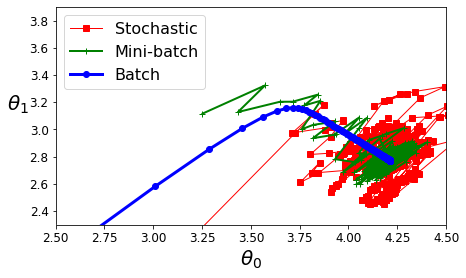

In [25]:
# Plotting the 3 Gradient Descents to compare their paths in parameter space

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

## Decision Trees

**Iris flower data set**

The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by the British statistician, eugenicist, and biologist Ronald Fisher in his 1936 paper The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis.

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

The iris data set is widely used as a beginner's dataset for machine learning purposes.

### Training our Decision Tree

In [26]:
# Importing the libraries and training a DecisionTreeClassfier

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### Visulising our decision tree

We can visualize the trained decision tree using the export_graphviz() method.

In [27]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file='iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True)

In [28]:
!dot -Tpng iris_tree.dot -o iris_tree.png

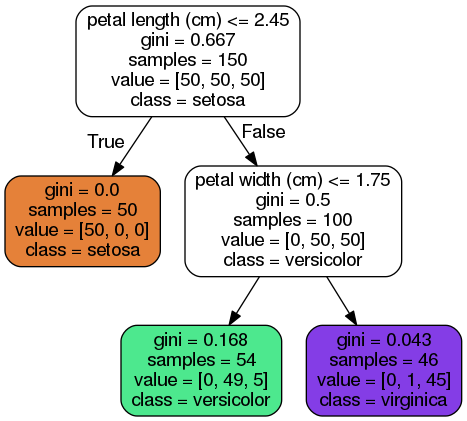

In [29]:
from IPython.display import Image
Image(filename='iris_tree.png')

### Estimating class probabilities

In [30]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [31]:
tree_clf.predict([[5, 1.5]])

array([1])

## Train SVM

In [32]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris virginica
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge")),
])
svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [33]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

## Unsupervised Learning - KMeans

In [34]:
# Get the points data

pointsdf = pd.read_csv("datasets/kmeans/points.csv")

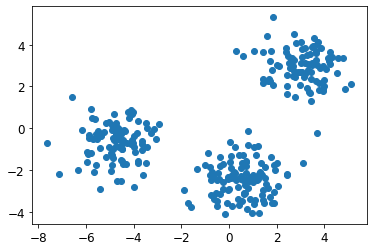

In [35]:
# Plot the points data

points = np.array(pointsdf)
xs = points[:, 0]
ys  = points[:, 1]

plt.scatter(xs, ys)

In [36]:
# Cluster using KMeans

from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
t = model.fit(points)
clusters = model.fit_predict(points)

In [37]:
# Predict new points 

new_points = [[4,3],[4,1],[-5,1]]
j = model.predict(new_points)
print(j)

[2 2 1]
